In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uciml_pima_indians_diabetes_database_path = kagglehub.dataset_download('uciml/pima-indians-diabetes-database')

print('Data source import complete.')


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8.91k/8.91k [00:00<00:00, 14.3MB/s]

Extracting files...
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1: Import Libraries

In [43]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
# Outlier Detection
from scipy import stats

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve


# 2: Load Dataset

In [6]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df.head()


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

# 3: Exploratory Data Analysis (EDA)

##  3.1: Basic Info

In [7]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 3.2: Visualize Distributions

<Axes: >

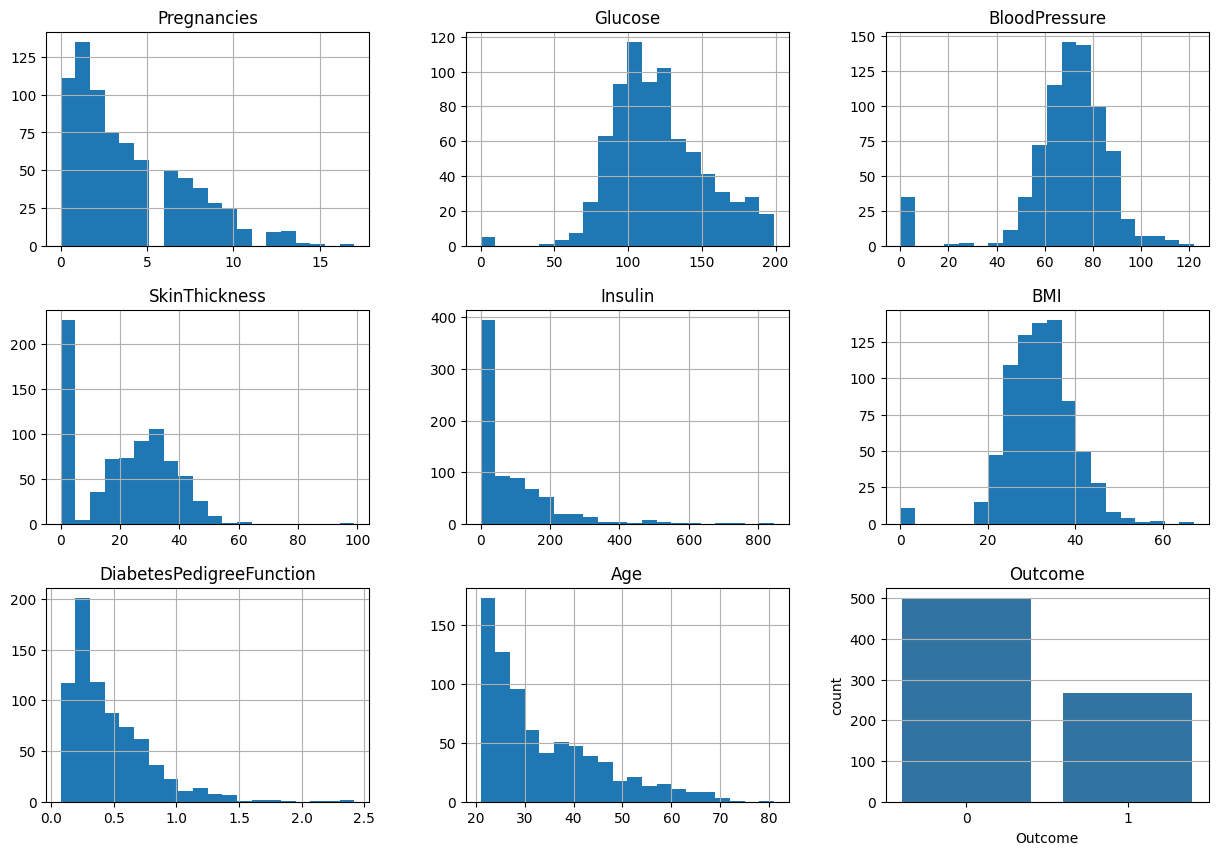

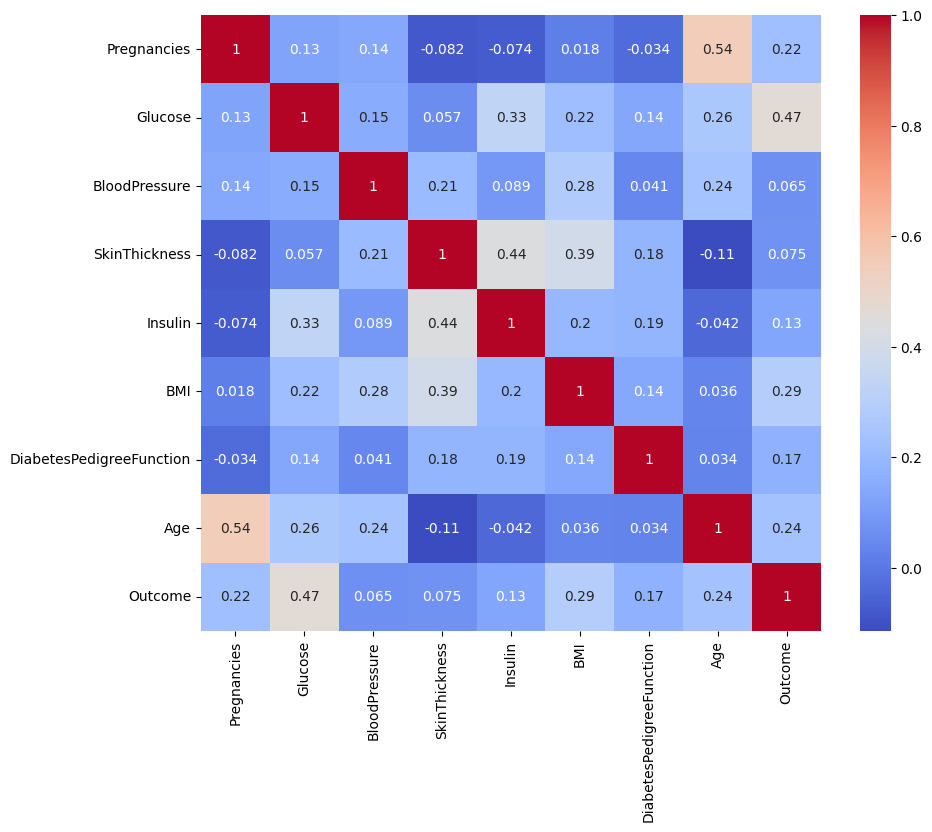

In [8]:
# Histograms
df.hist(figsize=(15,10), bins=20)

# Target count
sns.countplot(x='Outcome', data=df)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


##  3.3: Plotly Professional EDA

In [9]:
# Interactive correlation matrix
fig = px.imshow(df.corr(), text_auto=True, title='Correlation Matrix (Plotly)')
fig.show()

# Pair Plot
px.scatter_matrix(df, dimensions=df.columns[:-1], color='Outcome')


# 4: Data Cleaning & Preprocessing

## 4.1: Replace Invalid Zeroes

In [10]:
# Columns that cannot be zero
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zero with NaN
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)
df.isnull().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

## 4.2: Impute Missing Values

In [11]:
imputer = SimpleImputer(strategy='median')
df[cols_with_zero] = imputer.fit_transform(df[cols_with_zero])


# 5: Outlier Detection & Removal

##  5.1: Z-Score Method

In [12]:
z_scores = np.abs(stats.zscore(df.iloc[:, :-1]))
df = df[(z_scores < 3).all(axis=1)]


## 5.2: Optional IQR Method

In [13]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


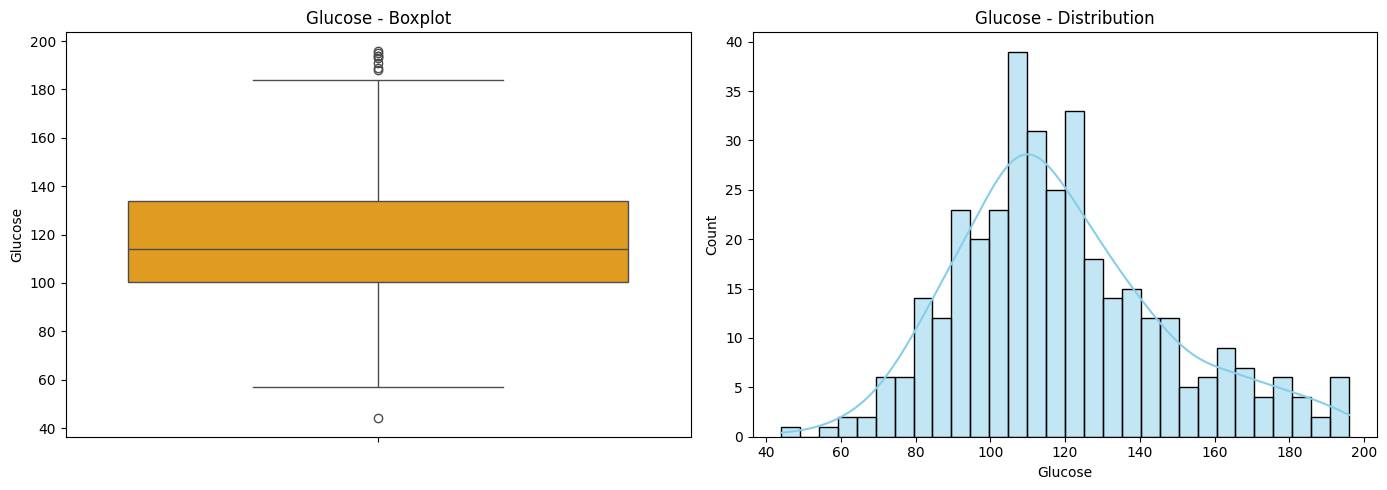

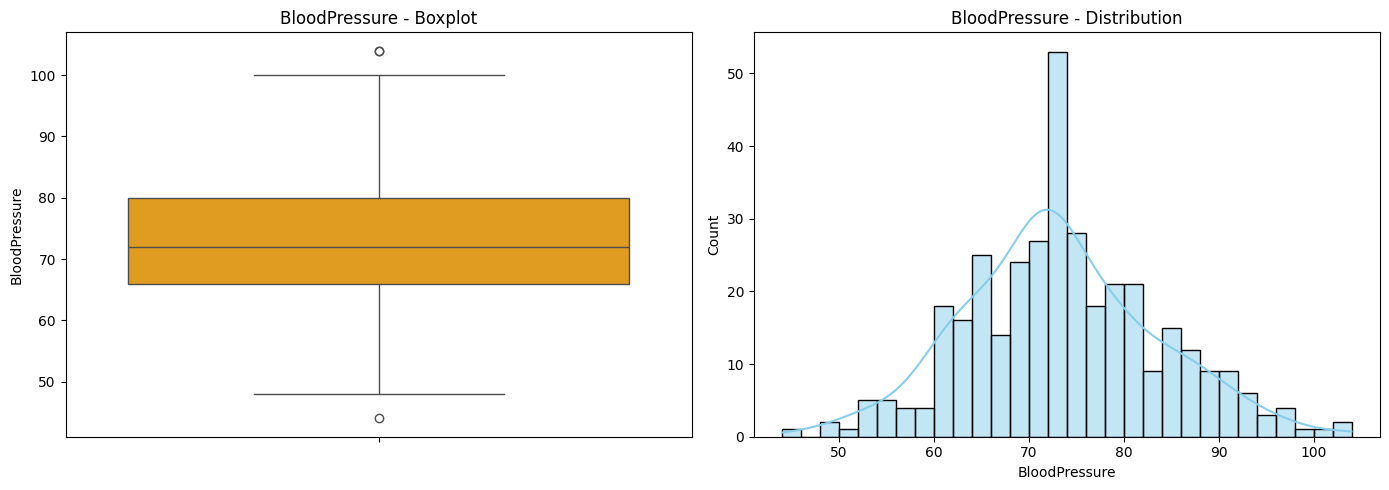

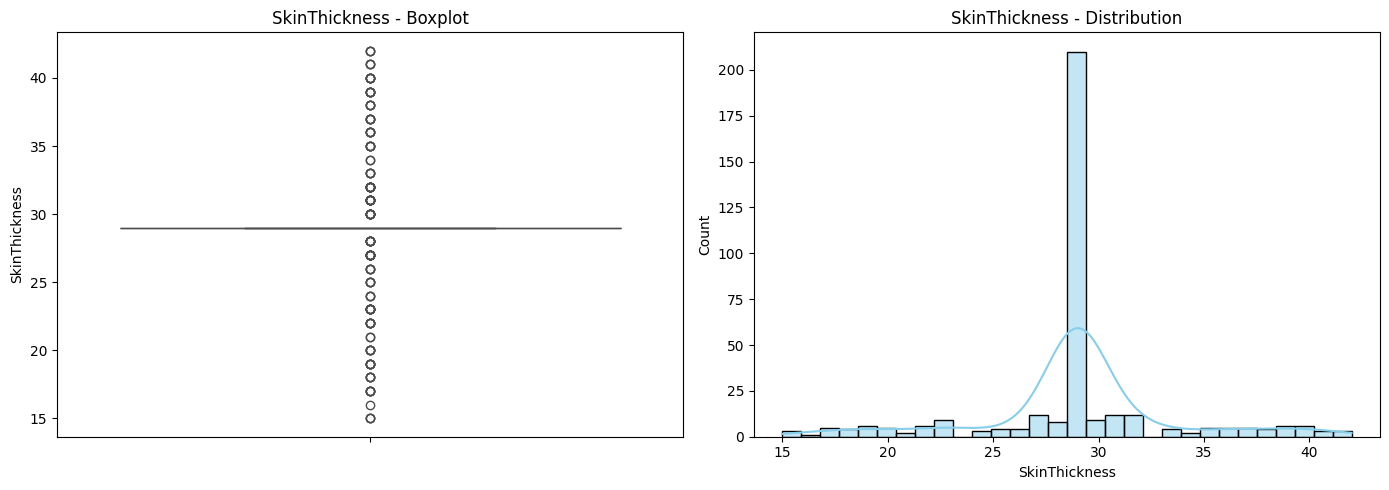

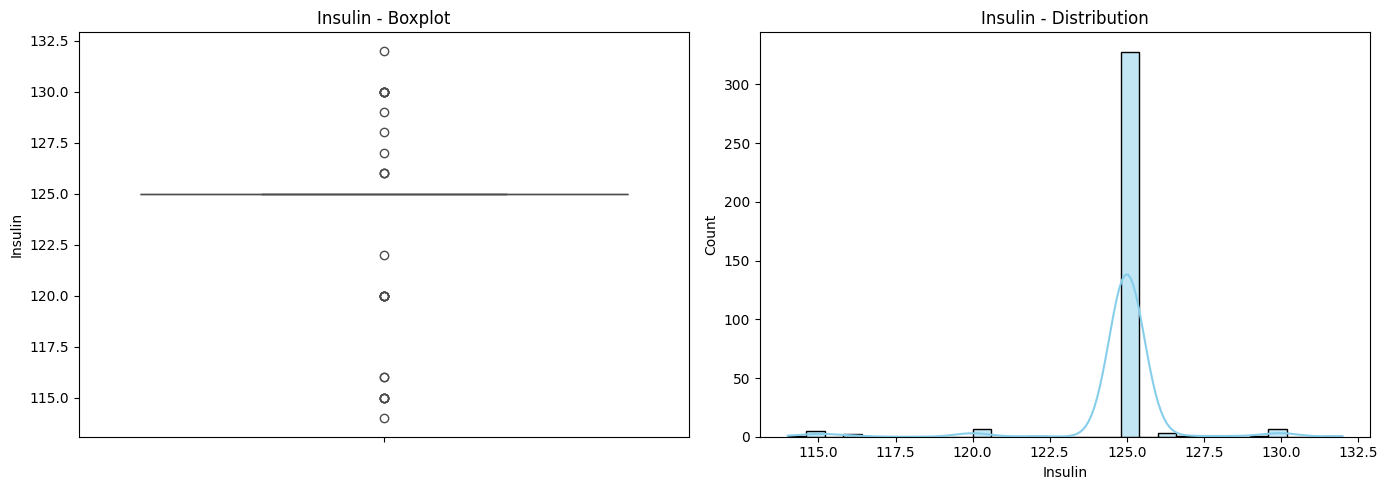

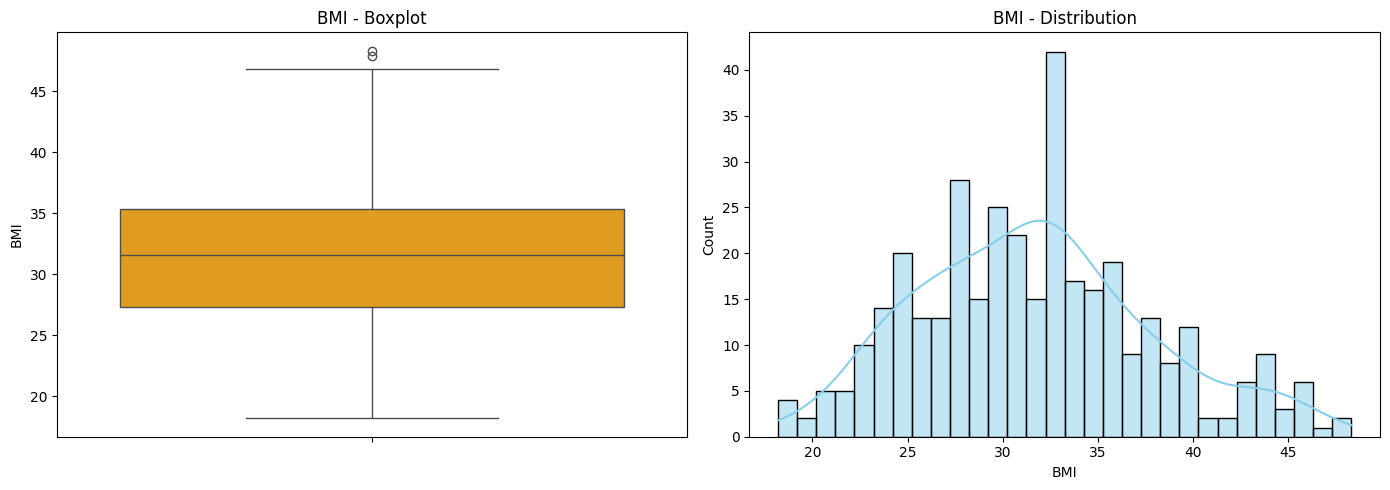

In [14]:
# List of continuous features to check for outliers
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_to_check:
    plt.figure(figsize=(14, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col], color='orange')
    plt.title(f'{col} - Boxplot')

    # Distribution Plot
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col} - Distribution')

    plt.tight_layout()
    plt.show()


‚ö†Ô∏è 3. SkinThickness
Boxplot: Too many outliers above the whiskers.

Distribution: Highly right-skewed.

‚ùóÔ∏èAction: Apply IQR Method to remove/cap extreme values.

In [15]:
# SkinThickness
Q1 = df['SkinThickness'].quantile(0.25)
Q3 = df['SkinThickness'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['SkinThickness'] >= lower) & (df['SkinThickness'] <= upper)]


‚ö†Ô∏è 4. Insulin
Boxplot: Several extreme outliers.

Distribution: Sharp spike with flat sides ‚Äî abnormal.

‚ùóÔ∏èAction: Consider using log-transform or IQR outlier removal.

In [16]:
# IQR method
Q1 = df['Insulin'].quantile(0.25)
Q3 = df['Insulin'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Insulin'] >= Q1 - 1.5 * IQR) & (df['Insulin'] <= Q3 + 1.5 * IQR)]


In [17]:
# Define a function for IQR-based outlier removal
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to SkinThickness and Insulin
df = remove_outliers_iqr(df, 'SkinThickness')
df = remove_outliers_iqr(df, 'Insulin')


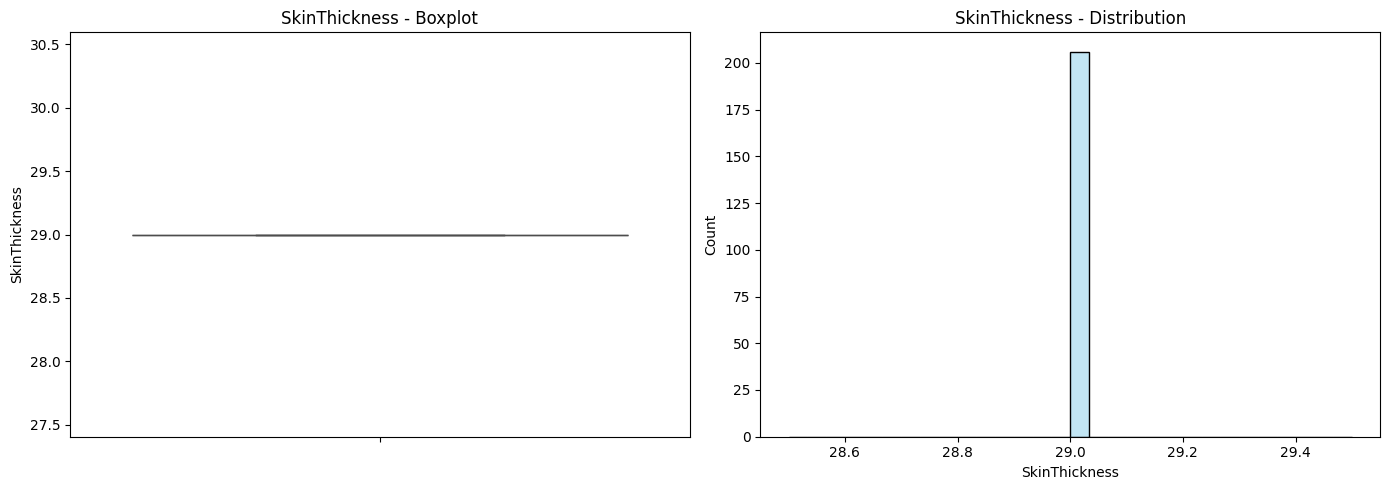

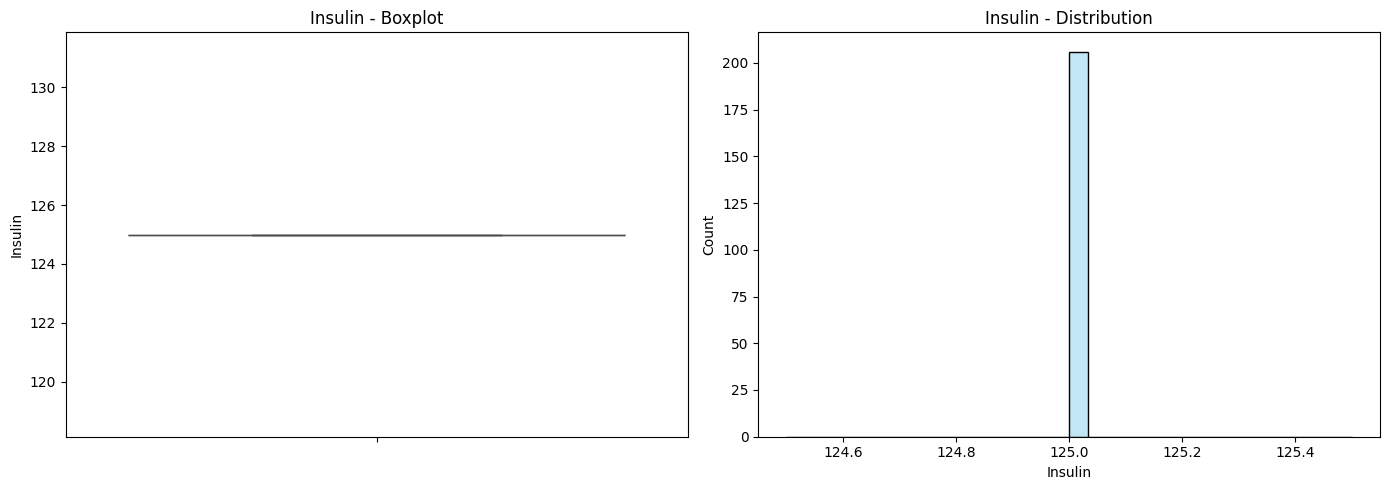

In [18]:
# List of columns to check
cols = ['SkinThickness', 'Insulin']

for col in cols:
    plt.figure(figsize=(14, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col], color='orange')
    plt.title(f'{col} - Boxplot')

    # Distribution plot
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col} - Distribution')

    plt.tight_layout()
    plt.show()

#  6: Feature Scaling



In [30]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

## Feature Selection

In [32]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=6)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)


# 8: Model Training

## üîπ Logistic Regression

In [33]:
model_lr = LogisticRegression(class_weight='balanced')
model_lr.fit(X_train_selected, y_train)

LogisticRegression(class_weight='balanced')

## üîπ XGBoost Classifier



In [34]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# 9: Model Evaluation

###  Ensemble Voting

In [35]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('lr', model_lr),
    ('xgb', model_xgb)
], voting='soft')

voting_model.fit(X_train_selected, y_train)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [36]:
# Predict
y_pred_vote = voting_model.predict(X_test_selected)
y_prob_vote = voting_model.predict_proba(X_test_selected)[:, 1]

# 10. Evaluation

In [37]:
# Metrics
print("\nüìä VotingClassifier Evaluation")
print("üîπ Accuracy:", accuracy_score(y_test, y_pred_vote))
print("üîπ ROC AUC Score:", roc_auc_score(y_test, y_prob_vote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))



üìä VotingClassifier Evaluation
üîπ Accuracy: 0.7142857142857143
üîπ ROC AUC Score: 0.780246913580247

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75        27
           1       0.57      0.80      0.67        15

    accuracy                           0.71        42
   macro avg       0.71      0.73      0.71        42
weighted avg       0.76      0.71      0.72        42



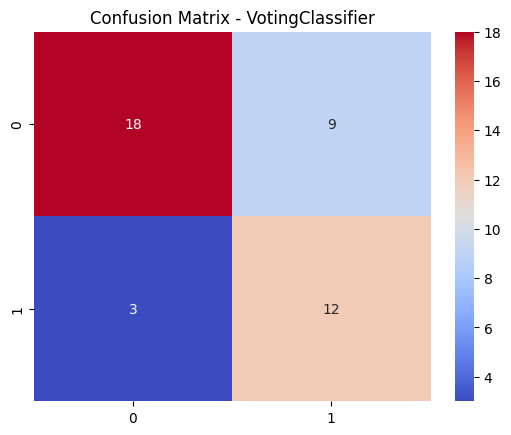

In [38]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_vote), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - VotingClassifier")
plt.show()


In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
# üîü Cross Validation on VotingClassifier
scores_vote_acc = cross_val_score(voting_model, X_train_selected, y_train, cv=5, scoring='accuracy')
scores_vote_auc = cross_val_score(voting_model, X_train_selected, y_train, cv=5, scoring='roc_auc')
print("\nüîÅ VotingClassifier CV Accuracy:", scores_vote_acc.mean())
print("üîÅ VotingClassifier CV ROC AUC :", scores_vote_auc.mean())


üîÅ VotingClassifier CV Accuracy: 0.756060606060606
üîÅ VotingClassifier CV ROC AUC : 0.8417813765182187


## üîπ ROC Curve

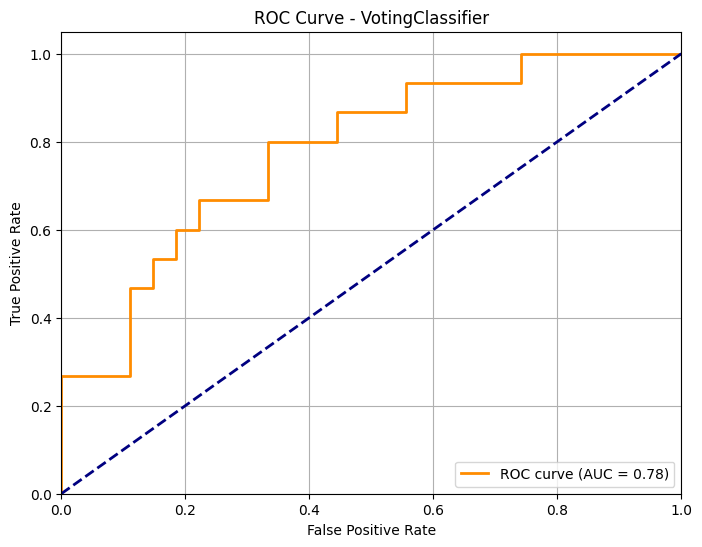

In [44]:
fpr, tpr, _ = roc_curve(y_test, y_prob_vote)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - VotingClassifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# ‚úÖ 2. Feature Importance / Coefficients (Logistic Regression)

<ipython-input-46-1205857602>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




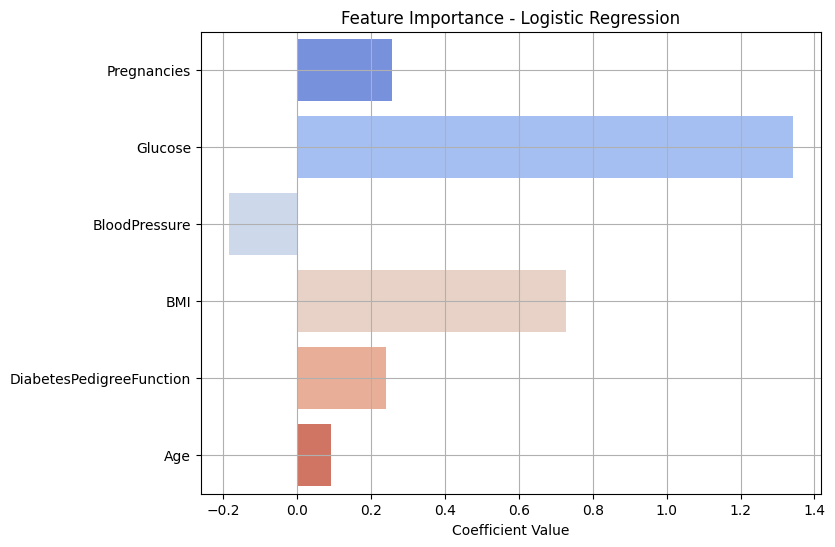

In [46]:
# Feature importance (coefficients)
import numpy as np
features = np.array(X.columns)[rfe.support_]
coefs = model_lr.coef_[0]

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=coefs, y=features, palette="coolwarm")
plt.title("Feature Importance - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.grid()
plt.show()


# ‚úÖ 3. Summary Table

In [47]:
# üßæ Summary Table
print("\nüìä‚úÖ Final VotingClassifier Model Summary")
print("-------------------------------------------------")
print(f"üîπ Test Accuracy           : {accuracy_score(y_test, y_pred_vote):.4f}")
print(f"üîπ Test ROC AUC            : {roc_auc_score(y_test, y_prob_vote):.4f}")
print(f"üîπ CV Accuracy (5-fold)    : {scores_vote_acc.mean():.4f}")
print(f"üîπ CV ROC AUC (5-fold)     : {scores_vote_auc.mean():.4f}")
print("-------------------------------------------------")



üìä‚úÖ Final VotingClassifier Model Summary
-------------------------------------------------
üîπ Test Accuracy           : 0.7143
üîπ Test ROC AUC            : 0.7802
üîπ CV Accuracy (5-fold)    : 0.7561
üîπ CV ROC AUC (5-fold)     : 0.8418
-------------------------------------------------


# ‚úÖ Save  Model using joblib

In [48]:
import joblib

# üíæ Save model pipeline
joblib.dump(voting_model, "voting_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(rfe, "rfe_selector.pkl")

['rfe_selector.pkl']

In [49]:
# üß† Prediction Function
def predict_diabetes_from_input():
    print("\nüîç Enter values for prediction:")
    features = []
    feature_names = X.columns
    for name in feature_names:
        value = float(input(f"{name}: "))
        features.append(value)

    # Create DataFrame and preprocess
    input_df = pd.DataFrame([features], columns=feature_names)
    scaled = scaler.transform(input_df)
    selected = rfe.transform(scaled)

    # Predict
    pred = voting_model.predict(selected)[0]
    prob = voting_model.predict_proba(selected)[0][1]

    print("\nü©∫ Prediction Result:")
    if pred == 1:
        print(f"‚úÖ At risk of diabetes with probability {prob:.2f}")
    else:
        print(f"‚ùé Not at risk of diabetes with probability {1 - prob:.2f}")

In [51]:
predict_diabetes_from_input()


üîç Enter values for prediction:
Pregnancies: 6
Glucose: 148
BloodPressure: 72
SkinThickness: 35
Insulin: 0
BMI: 33.6
DiabetesPedigreeFunction: 0.627
Age: 50

ü©∫ Prediction Result:
‚úÖ At risk of diabetes with probability 0.94
